In [23]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import lightkurve as lk
import tglc
import numpy as np

import os
from tglc.quick_lc import tglc_lc
import pickle
import glob

import pyMON.pyMON as pymon
from pyMON.pyMON import GetNumax, GetNumaxUncertainty
from astropy.convolution import Box1DKernel, convolve, Gaussian1DKernel, convolve_fft
from astropy.units import cds

from scipy import ndimage
#from skimage.measure import label

import matplotlib as mpl

In [24]:
hdul = fits.open('data/original_hon_catalog.fit')
data = hdul[1].data
table = Table(data)
mh = table.to_pandas()
hdul.close()

tics_to_keep = [459917383, 140578874, 176982730, 278702671, 147565895, 144066888, 167169718, 288661439, 142305400, 155896371, 309828103, 279615774, 235906010]
# Select only those rows, from figure 19 in mh2021
subset = mh[mh['TIC'].isin(tics_to_keep)].copy()

In [25]:
subset

,TIC,numax,e_numax,Tmag,Teff,e_Teff,Rstar,e_Rstar,Lstar,e_Lstar,Dist,e_Dist,RUWE,Flag,_RA,_DE
45239,140578874,37.3,2.5,8.0,4883,97,10.9,0.5,60.3,2.6,0.421,0.002,1.00,1,68.030649,-77.477397
46693,142305400,93.2,3.9,6.0,4787,95,6.6,0.3,20.5,0.6,0.105,0.000,0.88,1,41.387298,-42.838700
47925,144066888,59.1,3.3,8.0,5011,100,10.3,0.4,59.6,2.1,0.429,0.003,0.97,1,337.610637,-51.552294
49523,147565895,57.5,2.9,6.0,4750,95,7.5,0.3,25.6,0.8,0.113,0.000,1.05,1,163.680210,-42.018147
53314,155896371,91.5,3.8,8.0,4723,94,7.4,0.3,24.2,0.9,0.274,0.001,0.98,1,4.098704,-51.611425
59412,167169718,60.3,3.8,10.0,4788,95,7.5,0.4,26.7,1.5,0.686,0.005,1.01,1,97.008341,-66.627249
63033,176982730,31.4,2.2,10.0,4692,93,11.0,0.5,52.6,2.0,0.954,0.009,1.00,1,101.522427,-67.798416
80732,235906010,133.4,11.2,10.0,4796,95,5.3,0.2,13.3,0.4,0.489,0.003,1.07,1,290.352529,80.756842
96927,278702671,27.4,5.4,12.0,4846,96,10.1,0.5,50.8,3.6,2.420,0.076,1.00,1,334.579903,-41.530806
97637,279615774,124.6,5.6,8.0,4922,98,6.0,0.3,19.2,0.8,0.237,0.004,7.32,1,106.341828,-59.391192


In [26]:
tics = subset['TIC'].values
numaxes, e_numaxes, tmags = subset['numax'].values, subset['e_numax'].values, subset['Tmag'].values
snr_cls, snr_3x3 = [], []

In [31]:
i = 12
tic = tics[i]
numax = numaxes[i]
e_numax = e_numaxes[i]

### 
### Begin

In [32]:
def HighPassFilter(lc, highpass_filter = 4, method = 'Flatten', normalize = True):
    if method == 'Flatten':
        # High-pass filter. Default filter width is 4 days (attenuates frequency below 3 microHz)
        window_length =  int(np.shape(lc)[0]/((lc.time.value[-1]-lc.time.value[0])/highpass_filter))
    
        window_length = window_length ## get rid of the dimensions and convert to an int
        if window_length % 2 == 0:
            window_length += 1
    
        lc_corr = lc.flatten(window_length)
        
        if normalize:
            lc_corr = lc_corr.normalize(unit = 'ppm')
    
    elif method == 'Gaussian':
        filter_width = int(np.shape(lc)[0]/((lc.time.value[-1]-lc.time.value[0])/highpass_filter))
        
        high_passed = Gaussian_high_pass_filter(lc.flux.value, window_size = filter_width)

        lc_dict = {'time': lc.time.value, 'flux': high_passed *1.e3* cds.ppm}
        
        lc_corr = lk.LightCurve(lc_dict)

    lc_final = lc_corr.remove_outliers(3)
    
    return lc_final

def PSD(lc, sector = None, numax_est = None, min_freq = 3, max_freq = 280, oversample = 5):
    
    psd = lc.to_periodogram(method='lombscargle', normalization='psd', maximum_frequency = max_freq, minimum_frequency = min_freq, oversample_factor = oversample)
    
    return psd

def ps_smooth(frequency, power, numax_est, evol_stage, sm):
    """ This function should be executed after ps_no_slope """
    if evol_stage == 'RGB':
        dnu_est = 0.3*(numax_est)**0.75
    elif evol_stage == 'RHB':
        dnu_est = 0.3*(numax_est)**0.86
    elif evol_stage == 'AGB':
        dnu_est = 0.3*(numax_est)**0.77

    resolution = frequency[1] - frequency[0]

    ## following code taken from pysyd target function line 693
    if sm == None:
        numax_sun = 3090.00
        sm = 4.*(numax_est/numax_sun)**0.2
        if sm < 1.:
            sm = 1.


    sig = (sm*(dnu_est/resolution))/np.sqrt(8.0*np.log(2.0))
    # print(sig)   # sig is same as pySYD
    pssm = convolve_fft(np.copy(power), Gaussian1DKernel(int(sig)))


    return pssm

def txt_to_LC(file, label = None, normalised = True):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import lightkurve as lk
    from  lightkurve import periodogram
    from astropy import units as u
    from astropy.units import cds
    from astropy.time import Time
    
    time = file['time']
    flux = file['flux']
    
    time = Time(time, scale='tdb', format='btjd')

    if normalised == True:
        flux = flux * cds.ppm           # assign units of ppm for normalised lc
    else:
        flux = flux * u.electron/u.s           # assign units of ppm for non-normalised lc
    
    lc_dict = {'time': time, 'flux': flux}
    lc = lk.LightCurve(lc_dict)
    return lc

In [33]:
# read in 
directory = f'pipeline_outputs/TIC{tic}/'
lc_cls = pd.read_csv(f'{directory}corrected_lc_adaptive1.csv')
lc_3x3 = pd.read_csv(f'{directory}corrected_lc_3x3.csv')

lclc_cls = txt_to_LC(lc_cls)
lclc_3x3 = txt_to_LC(lc_3x3)

In [34]:
lclc_cls_hp = HighPassFilter(lclc_cls, highpass_filter = 2, method = 'Flatten', normalize = True)
lclc_3x3_hp = HighPassFilter(lclc_3x3, highpass_filter = 2, method = 'Flatten', normalize = True)

psd_cls = PSD(lclc_cls_hp, sector = None, numax_est = numax, min_freq = 3, max_freq = 0.5*1e6*(1/1800), oversample = 5)
psd_3x3 = PSD(lclc_3x3_hp, sector = None, numax_est = numax, min_freq = 3, max_freq = 0.5*1e6*(1/1800), oversample = 5)

In [35]:
from astropy.convolution import Box1DKernel, convolve, Gaussian1DKernel, convolve_fft

def ps_smooth(frequency, power, numax_est, sm):
    """ This function should be executed after ps_no_slope """
    
    dnu_est = 0.3*(numax_est)**0.75
    
    resolution = frequency[1] - frequency[0]

    ## following code taken from pysyd target function line 693
    if sm == None:
        numax_sun = 3090.00
        sm = 4.*(numax_est/numax_sun)**0.2
        if sm < 1.:
            sm = 1.


    sig = (sm*(dnu_est/resolution))/np.sqrt(8.0*np.log(2.0))
    # print(sig)   # sig is same as pySYD
    pssm = convolve_fft(np.copy(power), Gaussian1DKernel(int(sig)))


    return pssm

def get_PE_bounds(numax_est, lowerp, upperp):
    """ Get the boundaries of the power excess around the predicted numax """
    numax_sun = 3090.00
    width_sun = 1300.0
    #Get power excess mask
    width = width_sun*(numax_est/numax_sun)
    maxpower = [numax_est-(width), numax_est+(width)]

    if lowerp == None:
        lowerp = maxpower[0]

    if upperp == None:
        upperp = maxpower[1]

    ps_bounds = [lowerp, upperp]

    return ps_bounds
    
def get_linear_bg(frequency, power, numax_est, sm=2, lowerp = None, upperp = None):
    """
    Estimate the BG with a straight line. Linear in log!

    """
    smps = ps_smooth(frequency, power, numax_est, sm)

    ps_bounds = get_PE_bounds(numax_est, lowerp, upperp)
   

    #---Get vaules for linear fit:
    # print('PSMASK: ', ps_mask[0], ps_mask[1])
    mask = np.ma.getmask(np.ma.masked_inside(frequency, ps_bounds[0], ps_bounds[1]))
    smps = smps[mask]
    pwr1 = smps[0]
    
    pwr2 = smps[len(smps)-1]  #SWC: Get power values at start and end of excess region.
    # print('LINEARBG: pwr1, pwr2=',pwr1,pwr2)

    nu1 = ps_bounds[0]
    nu2 = ps_bounds[1]
    nu1 = np.log10(nu1)
    nu2 = np.log10(nu2)
    # print('LINEARBG: nu1,nu2=',nu1,nu2)


    offsetfrac = 0.0

    pwr1 = pwr1 - offsetfrac*pwr1
    pwr2 = pwr2 - offsetfrac*pwr1  #Move line down a bit.
    pwr1 = np.log10(pwr1)
    pwr2 = np.log10(pwr2)

    grad = (pwr2-pwr1)/(nu2-nu1)
    c = pwr1 - grad*nu1

    # print(f'Parameters of Linear Bkg model: grad = {grad}, c = {c}')


    # print('LINEARBG: offsetfrac, pwr1,pwr2,grad,c=',offsetfrac,pwr1,pwr2,grad,c)

    linbg = np.zeros(len(frequency))

    for i in range(len(frequency)):
        linbg[i] = 10.0**(grad*np.log10(frequency[i]) + c)
        #print('Linear BG, freq, i=',linbg[i],self.frequency[i],i)

    return linbg, ps_bounds

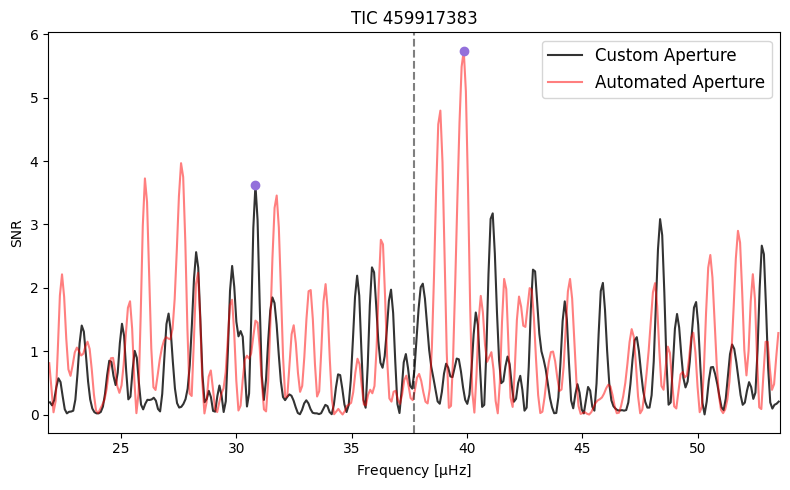

In [36]:
from scipy.signal import find_peaks

# find linear background model
psd_kepler = psd_cls
psd_tess = psd_3x3


linbg_kepler, ps_mask_kepler = get_linear_bg(psd_kepler.frequency.value, psd_kepler.power.value, numaxes[i], sm=2)
psd_bgcorr_kepler = psd_kepler.power.value/linbg_kepler
mask_kepler = (psd_kepler.frequency.value >= ps_mask_kepler[0]) & (psd_kepler.frequency.value <= ps_mask_kepler[1])

linbg_tess, ps_mask_tess = get_linear_bg(psd_tess.frequency.value, psd_tess.power.value, numaxes[i], sm=2)
psd_bgcorr_tess = psd_tess.power.value/linbg_tess
mask_tess = (psd_tess.frequency.value >= ps_mask_tess[0]) & (psd_tess.frequency.value <= ps_mask_tess[1])



# pssm = TESS_LC.ps_smooth(psd_tess.frequency.value, psd_bgcorr_tess, star.APOKASC3_NU_MAX.values[0], 'RGB', 2) 

fig, ax = plt.subplots(figsize = (8,5))

ax.plot(psd_kepler.frequency.value[mask_kepler], psd_bgcorr_kepler[mask_kepler], label = f'Custom Aperture', c = 'k', alpha = 0.8)
ax.plot(psd_tess.frequency.value[mask_tess], psd_bgcorr_tess[mask_tess], label = f'Automated Aperture', c = 'r', alpha=0.5)
#ax.scatter(psd_kepler.frequency.values[mask_kepler], psd_bgcorr_kepler[mask_kepler], c = 'k', alpha = 0.8)
#ax.scatter(psd_tess.frequency.values[mask_tess], psd_bgcorr_tess[mask_tess], c = 'r')

peaks, _ = find_peaks(psd_bgcorr_tess[mask_tess])
largest_peak_tess = np.argmax(psd_bgcorr_tess[mask_tess][peaks])
snr_max_tess = psd_bgcorr_tess[mask_tess][peaks][largest_peak_tess]
ax.scatter(psd_tess.frequency.value[mask_tess][peaks][largest_peak_tess], snr_max_tess, c = 'mediumpurple', zorder = 10)
snr_3x3.append(snr_max_tess)


peaks, _ = find_peaks(psd_bgcorr_kepler[mask_kepler])
largest_peak_kepler = np.argmax(psd_bgcorr_kepler[mask_kepler][peaks])
snr_max_kepler =  psd_bgcorr_kepler[mask_kepler][peaks][largest_peak_kepler]
ax.scatter(psd_kepler.frequency.value[mask_kepler][peaks][largest_peak_kepler], snr_max_kepler, c = 'mediumpurple', zorder = 10)
snr_cls.append(snr_max_kepler)

ax.axvline(numaxes[i], c = 'k', ls = 'dashed', alpha = 0.5)


# ax.set_ylim(-0.1, 4.e6) 
ax.set_xlim(ps_mask_kepler[0],ps_mask_kepler[1])
ax.legend(loc = 'best', fontsize = 12)

#ylabel = "Power"

#unit_label = psd_tess.power.unit.to_string("latex")
# The line below is a workaround for AstroPy bug #9218.
# It can be removed once the fix for that issue is widespread.
# See https://github.com/astropy/astropy/pull/9218
#unit_label = re.sub(
#    r"\^{([^}]+)}\^{([^}]+)}", r"^{\g<1>^{\g<2>}}", unit_label
#)
#ylabel += " [{}]".format(unit_label)


xlabel = r"Frequency [$\mathrm{\mu Hz}$]"

ax.set_xlabel(xlabel), ax.set_ylabel('SNR')
ax.set_title(f'TIC {tics[i]}')

fig.tight_layout()
#plt.savefig(f'Figures/TIC{tics[i]}_comparison.png', dpi=300)

In [40]:
#df = pd.DataFrame({'TIC':tics,'Tmag':tmags,'numax':numaxes,'snr_cls':snr_cls,'snr_3x3':snr_3x3})
#df.to_csv('SNRs.csv')
df = pd.read_csv('SNRs.csv')
df

,Unnamed: 0,TIC,Tmag,numax,snr_cls,snr_3x3
0,0,140578874,8.0,37.3,12.239169,6.041923
1,1,142305400,6.0,93.2,5.490546,8.719942
2,2,144066888,8.0,59.1,10.833958,17.389758
3,3,147565895,6.0,57.5,4.684832,5.003212
4,4,155896371,8.0,91.5,6.471897,9.236724
5,5,167169718,10.0,60.3,10.914926,6.453046
6,6,176982730,10.0,31.4,4.171693,4.171693
7,7,235906010,10.0,133.4,12.533053,8.221414
8,8,278702671,12.0,27.4,6.036802,4.592081
9,9,279615774,8.0,124.6,5.109956,4.963223


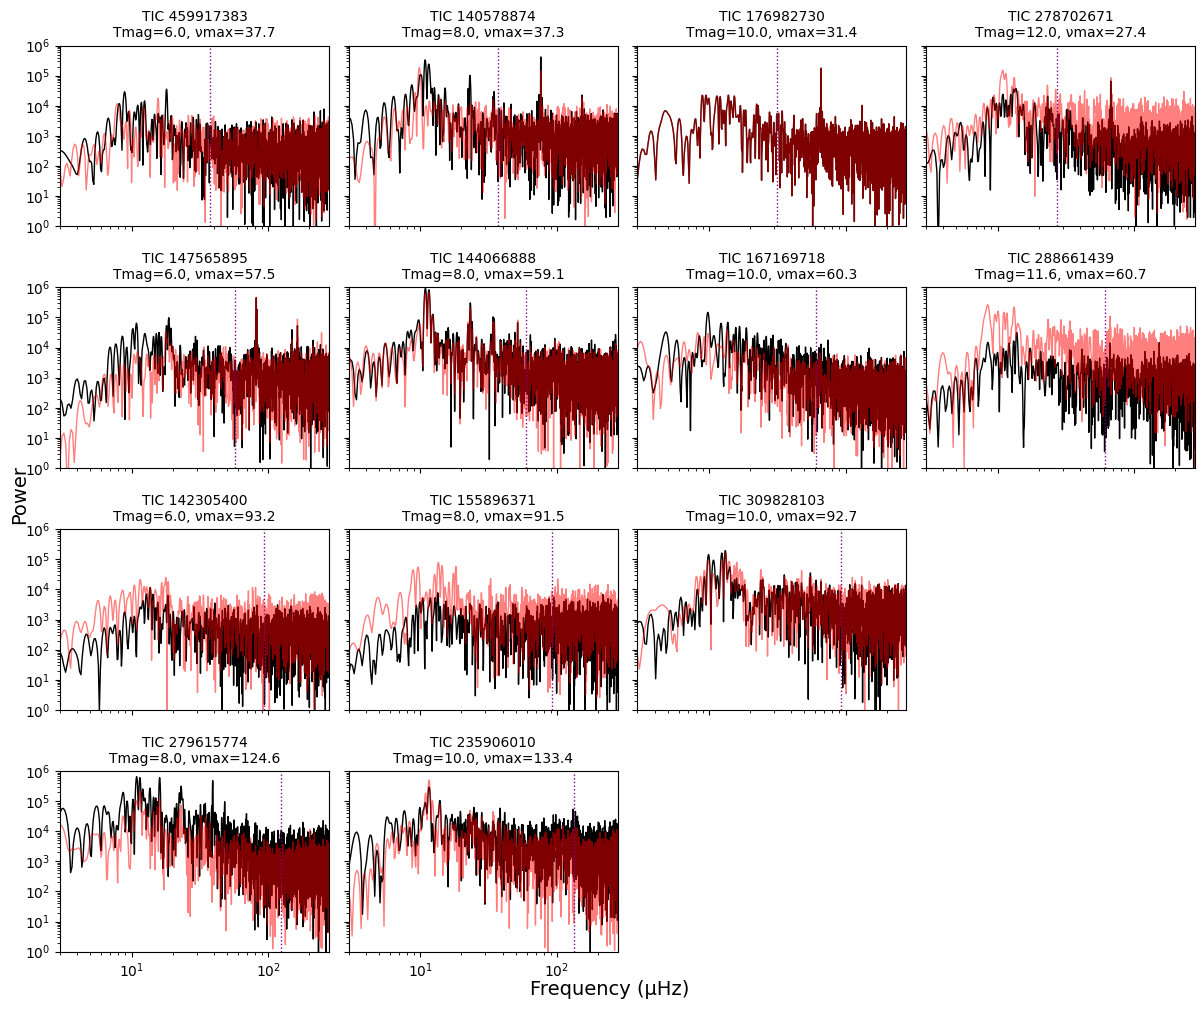

In [45]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Define numax bins manually (edges can be tuned as needed)
bins = [0, 45, 75, 105, 150]  # Rough boundaries for 30, 60, 90, 120 μHz
labels = [1, 2, 3, 4]
subset['numax_bin'] = pd.cut(subset['numax'], bins=bins, labels=labels, include_lowest=True)

# --- Sort each bin by decreasing brightness (smaller Tmag = brighter)
binned_rows = []
for label in labels:
    bin_df = subset[subset['numax_bin'] == label].sort_values('Tmag', ascending=True)
    binned_rows.append(bin_df)

# --- Define grid shape (4x4)
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10), sharex=True, sharey=True)

# --- Optional: define empty positions for rows with fewer stars
# Row 3 → 3 stars (one empty)
# Row 4 → 2 stars (two empty)
empty_indices = [(2, 3), (3, 2), (3, 3)]

# --- Loop over grid positions
for r in range(nrows):
    for c in range(ncols):
        ax = axes[r, c]

        # Skip predefined empty slots
        if (r, c) in empty_indices:
            ax.axis('off')
            continue

        # Get star for this position if available
        try:
            row = binned_rows[r].iloc[c]
        except (IndexError, KeyError):
            ax.axis('off')
            continue

        tic = row['TIC']
        numax = row['numax']
        tmag = row['Tmag']

        directory = f'pipeline_outputs/TIC{int(tic)}/'
        lc_cls = pd.read_csv(f'{directory}corrected_lc_adaptive1.csv')
        lc_3x3 = pd.read_csv(f'{directory}corrected_lc_3x3.csv')

        # --- Build PSD (assuming you already defined these functions)
        lclc_cls = txt_to_LC(lc_cls)
        lclc_cls_hp = HighPassFilter(lclc_cls, highpass_filter=2, method='Flatten', normalize=True)
        psd_cls = PSD(lclc_cls_hp, sector=None, numax_est=numax,
                      min_freq=3, max_freq=0.5*1e6*(1/1800), oversample=5)
        lclc_3x3 = txt_to_LC(lc_3x3)
        lclc_3x3_hp = HighPassFilter(lclc_3x3, highpass_filter=2, method='Flatten', normalize=True)
        psd_3x3 = PSD(lclc_3x3_hp, sector=None, numax_est=numax,
                      min_freq=3, max_freq=0.5*1e6*(1/1800), oversample=5)

        freq1 = psd_cls.frequency.value
        power1 = psd_cls.power.value
        freq2 = psd_3x3.frequency.value
        power2 = psd_3x3.power.value

        ax.loglog(freq1, power1, color='k', lw=1)
        ax.loglog(freq2, power2, color='r', lw=1, alpha=0.5)
        ax.set_title(f"TIC {int(tic)}\nTmag={tmag:.1f}, νmax={numax:.1f}", fontsize=10)
        ax.set_ylim(1e0, 1e6)
        ax.set_xlim(3e0, 0.5*1e6*(1/1800))
        ax.axvline(numax, c='purple', lw=1., ls=':')

# --- Label axes
fig.text(0.5, 0.00, 'Frequency (µHz)', ha='center', fontsize=14)
fig.text(0.00, 0.5, 'Power', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()
plt.show()



In [518]:
tic

np.float64(278702671.0)